In [16]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [17]:
import pathlib
data_dir = 'BM-classification'
data_dir = pathlib.Path(data_dir).with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1138


In [18]:
batch_size = 16
img_height = 200
img_width = 200


In [19]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Found 1138 files belonging to 2 classes.
Using 911 files for training.
Found 1138 files belonging to 2 classes.
Using 227 files for validation.


In [20]:
class_names = train_ds.class_names
print(class_names)

['Benign', 'Malignant']


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [23]:
num_classes = len(class_names)

from tensorflow.keras import regularizers

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),

    # Conv Block 1
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.MaxPooling2D(),

    # Conv Block 2
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.MaxPooling2D(),

    # Conv Block 3
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.MaxPooling2D(),

    # Regularization
    layers.Dropout(0.3),

    # Fully Connected
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),

    # Output
    layers.Dense(num_classes, name="outputs")
])


In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
#Model Fitting

epochs = 45

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight={0: 1.0, 1: 1.35}
)

Epoch 1/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.6177 - loss: 1.0031 - val_accuracy: 0.7577 - val_loss: 0.6925
Epoch 2/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6721 - loss: 0.8619 - val_accuracy: 0.8150 - val_loss: 0.5786
Epoch 3/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.7225 - loss: 0.7643 - val_accuracy: 0.6828 - val_loss: 0.6993
Epoch 4/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.7208 - loss: 0.7746 - val_accuracy: 0.7885 - val_loss: 0.6333
Epoch 5/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.7737 - loss: 0.7350 - val_accuracy: 0.8106 - val_loss: 0.5917
Epoch 6/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.7466 - loss: 0.7614 - val_accuracy: 0.8238 - val_loss: 0.6103
Epoch 7/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.7590 - loss: 0.7522 - val_accuracy: 0.7974 - val_loss: 0.6286
Epoch 8/45
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.7845 - loss: 0.7166 - val_accuracy: 0.7885 - v

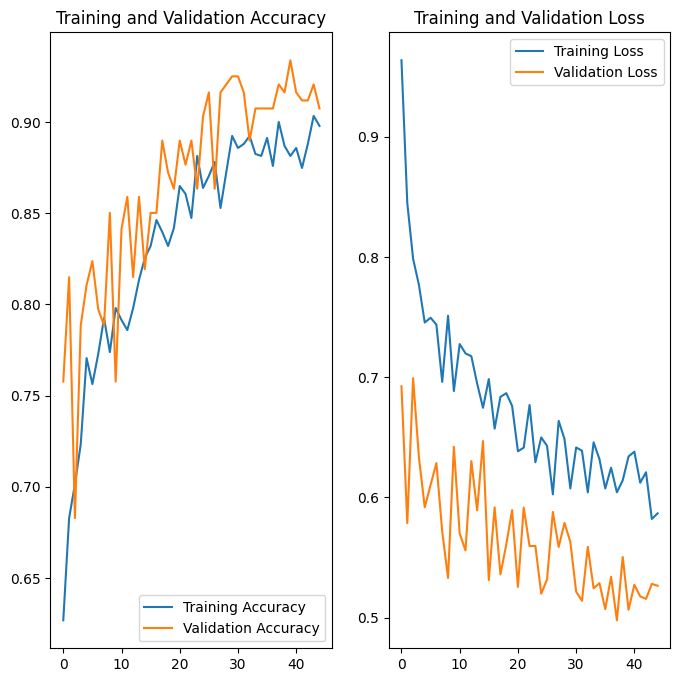

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

plt.show()

y_true shape: (227,)  | unique: [0 1]
y_pred shape: (227,)  | unique: [0 1]


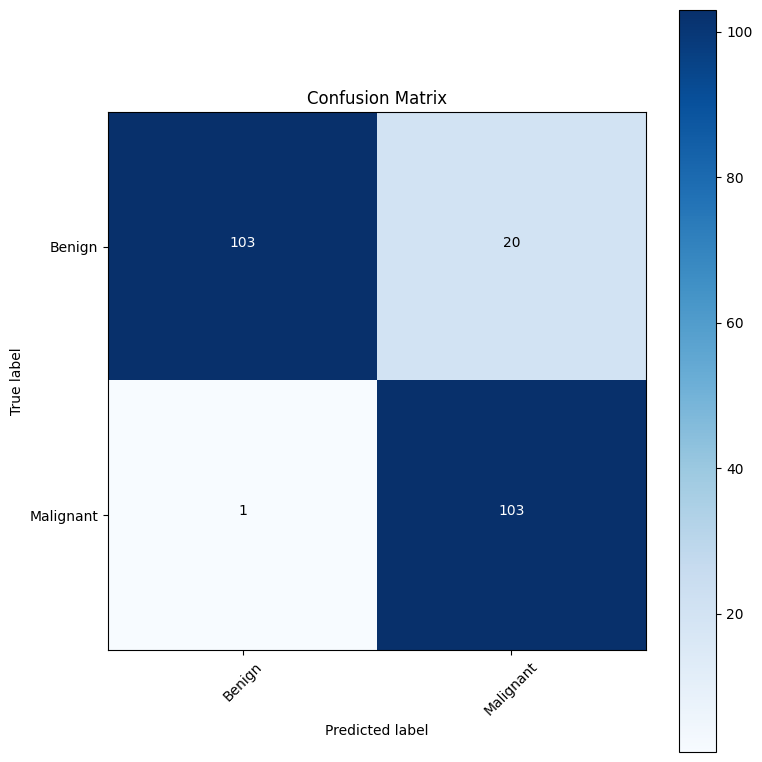

True Positives (TP): 103
False Positives (FP): 20
True Negatives (TN): 103
False Negatives (FN): 1



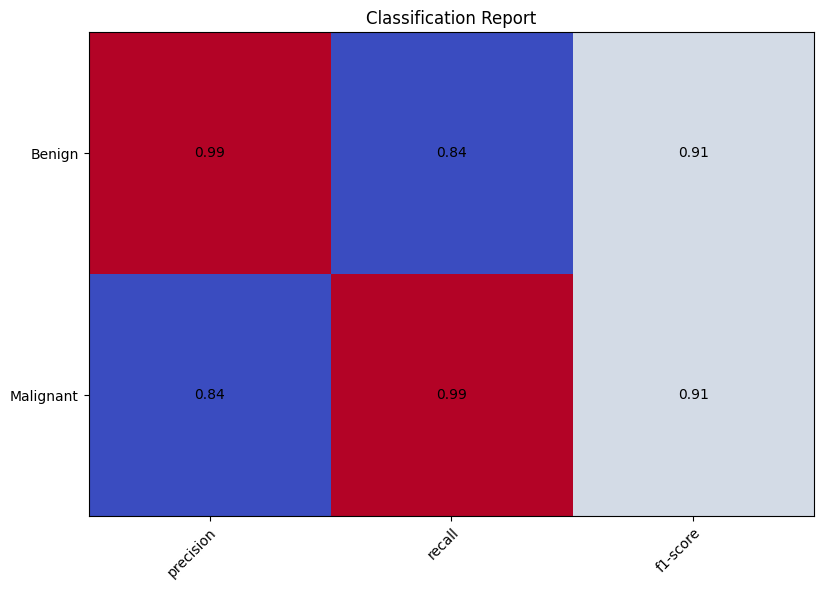

In [39]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

y_true = []
y_pred_logits = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())                          
    logits = model.predict(images, verbose=0)
    y_pred_logits.extend(logits)

y_true = np.array(y_true).astype("int32").squeeze()
y_pred_logits = np.array(y_pred_logits)

y_pred_probs = tf.nn.softmax(y_pred_logits, axis=1).numpy()

y_pred = np.argmax(y_pred_probs, axis=1)

print("y_true shape:", y_true.shape, " | unique:", np.unique(y_true))
print("y_pred shape:", y_pred.shape, " | unique:", np.unique(y_pred))

cm = confusion_matrix(y_true, y_pred)
# Plot the confusion matrix from white to dark blue
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
#add values to the confusion matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.title('Confusion Matrix')
plt.show()
tn, fp, fn, tp = cm.ravel()

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")
print()

# Example: class_names = ['Benign', 'Malignant']
# report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Simulated DataFrame for demo (replace this with your real report_df)
report_df = pd.DataFrame({
    'precision': [0.99, 0.84],
    'recall': [0.84, 0.99],
    'f1-score': [0.91, 0.91]
}, index=['Benign', 'Malignant'])

# Plot
fig, ax = plt.subplots(figsize=(10, 6))  # Larger figure
im = ax.imshow(report_df.values, cmap="coolwarm")  # Lighter colormap

# Set ticks
ax.set_xticks(np.arange(len(report_df.columns)))
ax.set_yticks(np.arange(len(report_df.index)))
ax.set_xticklabels(report_df.columns)
ax.set_yticklabels(report_df.index)

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate each cell
for i in range(len(report_df.index)):
    for j in range(len(report_df.columns)):
        value = report_df.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="black")

# Title and layout
ax.set_title("Classification Report")
fig.tight_layout()
plt.show()


In [ ]:
#MODEL ALREADY LOADED DO NOT OVERWRITE
model.save("BM_model.keras")

In [31]:
import random
reloaded = tf.keras.models.load_model("saved_models\BM_model.keras")
#test on a random image
val_loss, val_accuracy = reloaded.evaluate(val_ds)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

<>:2: SyntaxWarning: invalid escape sequence '\B'
<>:2: SyntaxWarning: invalid escape sequence '\B'
C:\Users\mattpenguiy\AppData\Local\Temp\ipykernel_71276\600679711.py:2: SyntaxWarning: invalid escape sequence '\B'
  reloaded = tf.keras.models.load_model("saved_models\BM_model.keras")


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9204 - loss: 0.4436
Validation Loss: 0.45311239361763, Validation Accuracy: 0.9207048416137695


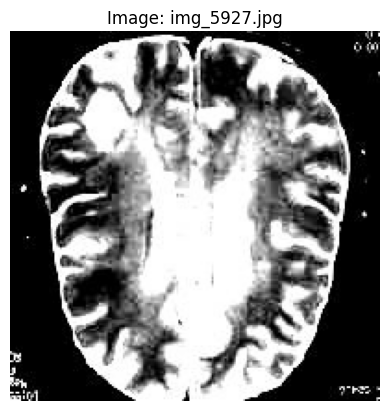

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Image: img_5927.jpg, Predicted Class: Benign, True Class: Benign


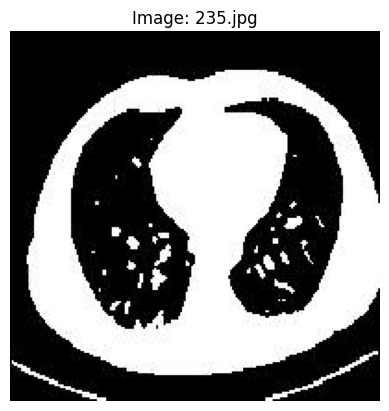

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image: 235.jpg, Predicted Class: Benign, True Class: Benign


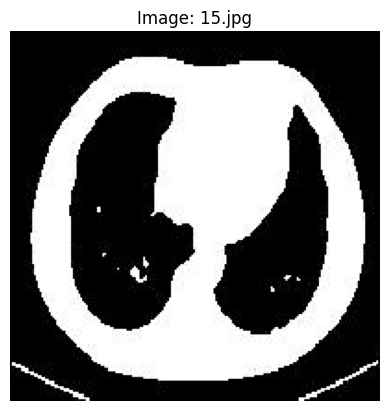

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Image: 15.jpg, Predicted Class: Benign, True Class: Benign


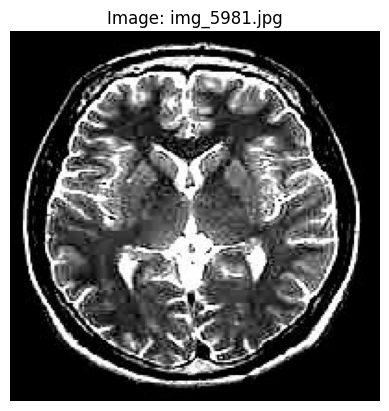

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Image: img_5981.jpg, Predicted Class: Benign, True Class: Benign


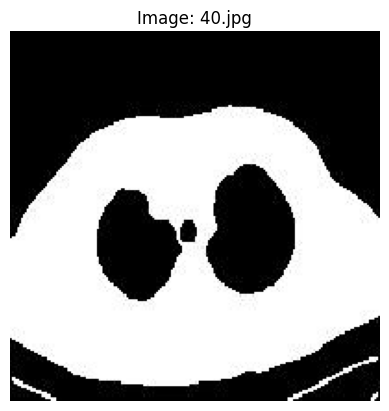

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Image: 40.jpg, Predicted Class: Benign, True Class: Benign






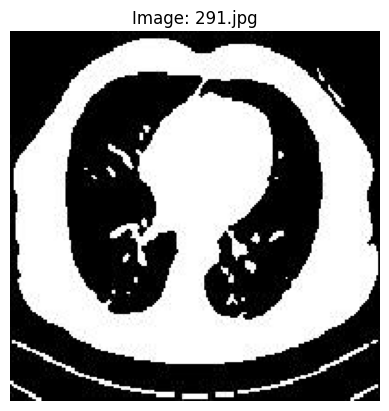

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Image: 291.jpg, Predicted Class: Malignant, True Class: Malignant


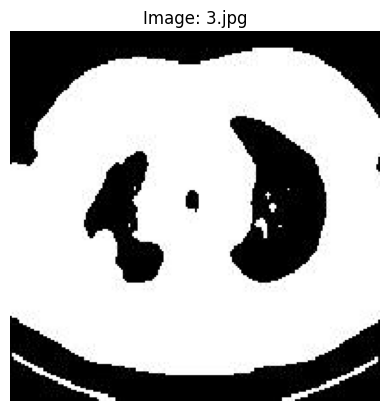

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Image: 3.jpg, Predicted Class: Malignant, True Class: Malignant


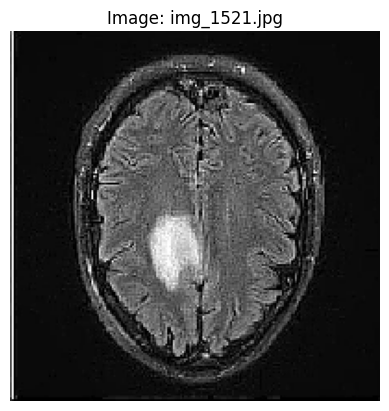

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image: img_1521.jpg, Predicted Class: Malignant, True Class: Malignant


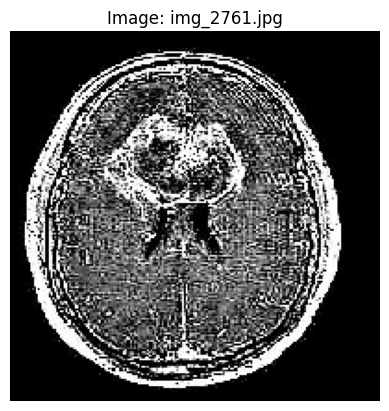

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Image: img_2761.jpg, Predicted Class: Malignant, True Class: Malignant


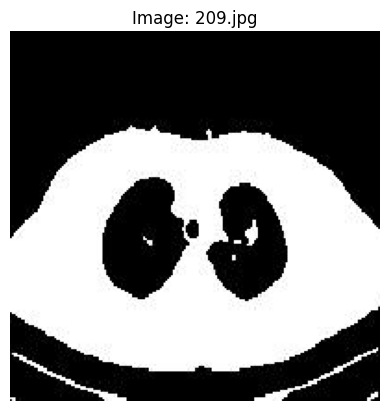

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: 209.jpg, Predicted Class: Malignant, True Class: Malignant


In [36]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

# Directory containing the images
B_dir = os.path.join(data_dir, "Benign")
M_dir = os.path.join(data_dir, "Malignant")

# Get a list of all image file paths in the "yes" directory
image_paths_B = list(pathlib.Path(B_dir).glob("*.jpg"))
image_paths_M = list(pathlib.Path(M_dir).glob("*.jpg"))


test_num= 5    # Change to the desired number of random images

# Select a random subset of images
random_images_B = random.sample(image_paths_B, test_num)  
random_images_M = random.sample(image_paths_M, test_num) 

# Predict the class for each random image (BENIGN)
for image_path in random_images_B:
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension

    # Display the image
    plt.figure()
    plt.imshow(img)
    plt.title(f"Image: {image_path.name}")
    plt.axis("off")
    plt.show()

    # Predict the class
    predictions = reloaded.predict(img_array)
    predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

    # Print the result
    print(f"Image: {image_path.name}, Predicted Class: {predicted_class}, True Class: Benign")

print("\n\n\n")
# Predict the class for each random image (MALIGNANT)
for image_path in random_images_M:
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension

    # Display the image
    plt.figure()
    plt.imshow(img)
    plt.title(f"Image: {image_path.name}")
    plt.axis("off")
    plt.show()

    # Predict the class
    predictions = reloaded.predict(img_array)
    predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

    # Print the result
    print(f"Image: {image_path.name}, Predicted Class: {predicted_class}, True Class: Malignant")


Micro-average ROC-AUC (OvR):    0.9754
Macro-average ROC-AUC (OvR):    0.9785
Weighted-average ROC-AUC (OvR): 0.9785
Per-class ROC-AUC (OvR):        [0.97850219 0.97850219]


C:\Users\mattpenguiy\AppData\Local\Temp\ipykernel_71276\2382866817.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10').colors  # or define your own list


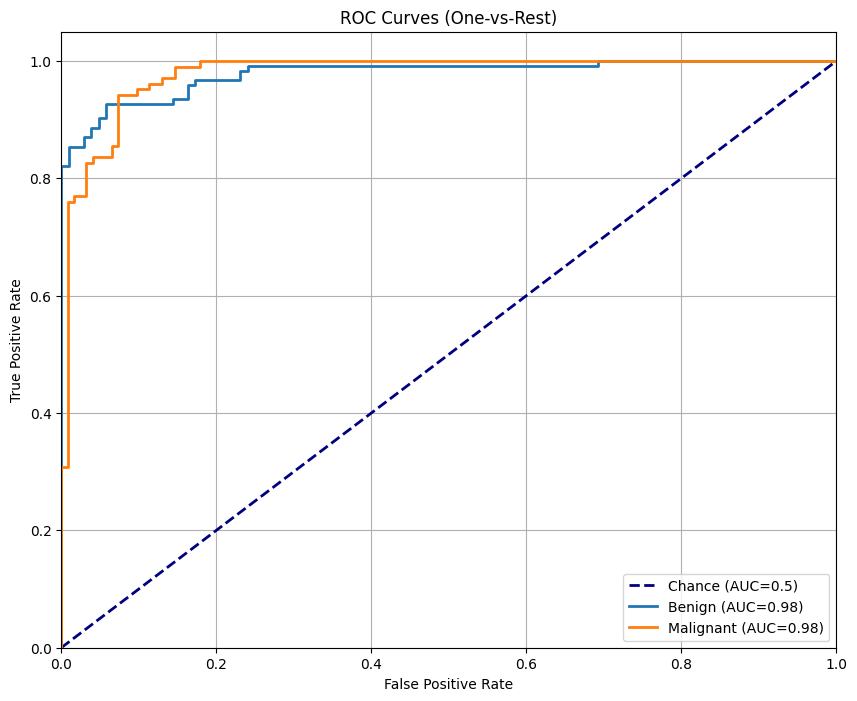

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Assuming you've already computed:
#   y_true      → shape (n_samples,)
#   y_pred_probs→ shape (n_samples, num_classes)
# If not, compute them as in your confusion‐matrix cell.

# 1) One‐hot encode the true labels
num_classes = y_pred_probs.shape[1]
y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes)

# 2) Compute OvR ROC‐AUC scores
try:
    roc_auc_micro_ovr    = roc_auc_score(y_true_onehot, y_pred_probs, multi_class='ovr', average='micro')
    roc_auc_macro_ovr    = roc_auc_score(y_true_onehot, y_pred_probs, multi_class='ovr', average='macro')
    roc_auc_weighted_ovr = roc_auc_score(y_true_onehot, y_pred_probs, multi_class='ovr', average='weighted')
    per_class_auc_ovr    = roc_auc_score(y_true_onehot, y_pred_probs, multi_class='ovr', average=None)

    print(f"Micro-average ROC-AUC (OvR):    {roc_auc_micro_ovr:.4f}")
    print(f"Macro-average ROC-AUC (OvR):    {roc_auc_macro_ovr:.4f}")
    print(f"Weighted-average ROC-AUC (OvR): {roc_auc_weighted_ovr:.4f}")
    print(f"Per-class ROC-AUC (OvR):        {per_class_auc_ovr}")
except ValueError as e:
    print(f"\nError calculating ROC-AUC: {e}")
    print("Make sure your test set contains all classes.")

# 3) Plot per-class ROC curves
colors = plt.cm.get_cmap('tab10').colors  # or define your own list

plt.figure(figsize=(10, 8))
lw = 2
# Chance line
plt.plot([0,1], [0,1], linestyle='--', color='navy', lw=lw, label='Chance (AUC=0.5)')

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    label = class_names[i] if i < len(class_names) else f"Class {i}"
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=lw,
             label=f"{label} (AUC={per_class_auc_ovr[i]:.2f})")

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:

reloaded = keras.models.load_model("BM_model.keras")
reloaded.evaluate(val_ds)



15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9204 - loss: 0.4436


[0.45311239361763, 0.9207048416137695]